




<img src="https://github.com/djp840/MSDS_458_Public/blob/master/images/NorthwesternHeader.png?raw=1">

## MSDS458 Final Assignment
<div class="alert alert-block alert-success">
    <b>More Technical</b>: Throughout the notebook. This types of boxes provide more technical details and extra references about what you are seeing. They contain helpful tips, but you can safely skip them the first time you run through the code.
</div><br>

This assignment is using image and farm data from DreamWorks Animation

<div class="alert alert-block alert-info">
<b>Dreamworks animation</b><br>
https://www.dreamworks.com/
    </div>

## Import packages needed 

In [21]:
import datetime
import time
import numpy as np
import pandas as pd
import cv2
import timeit
from scipy import stats
from packaging import version
from collections import Counter

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import r2_score as R2
from sklearn.metrics import explained_variance_score as EV
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, BatchNormalization, Dropout, Flatten, Input, Dense
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical

from keras.preprocessing.image import ImageDataGenerator, NumpyArrayIterator, array_to_img
from keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from sklearn.pipeline import Pipeline

In [2]:
%matplotlib inline
np.set_printoptions(precision=3, suppress=True)

## Verify TensorFlow Version and Keras Version

In [3]:
print("This notebook requires TensorFlow 2.0 or above")
print("TensorFlow version: ", tf.__version__)
assert version.parse(tf.__version__).release[0] >=2

This notebook requires TensorFlow 2.0 or above
TensorFlow version:  2.8.1


In [4]:
print("Keras version: ", keras.__version__)

Keras version:  2.8.0


## Mount Google Drive to Colab Environment

In [5]:
#from google.colab import drive
#drive.mount('/content/gdrive')

## Functions for Research Assignment

In [2]:

def resize_img(img, max_dim=128):
    max_ax = max((0, 1), key=lambda i: img.size[i])
    # Scale both axes so the image's largest dimension is max_dim
    scale = max_dim / float(img.size[max_ax])
    return img.resize((int(img.size[0] * scale), int(img.size[1] * scale)))


def load_image_data(files, max_dim=128, center=True):
    
    X = np.empty((len(files), max_dim, max_dim, 3))
    
    for i, fn in enumerate(files):
        # Turn the image into an array
        x = resize_img(load_img(fn, grayscale=False), max_dim=max_dim)
        x = img_to_array(x)
        length = x.shape[0]
        width = x.shape[1]
        if center:
            h1 = int((max_dim - length) / 2)
            h2 = h1 + length
            w1 = int((max_dim - width) / 2)
            w2 = w1 + width
        else:
            h1, w1 = 0, 0
            h2, w2 = (length, width)
            
        # Insert into image matrix
        X[i, h1:h2, w1:w2, 0:3] = x
        
    # Scale the array values so they are between 0 and 1
    return np.around(X / 255.0)

## Loading Dreamworks Dataset

The dataset I created from Dreamworks consists of 2500 236 × 102px colour images and regression data for RU (Render units, a normalized number representing the amount of compute per individual frame) per frame for that particular sequence and shot data. 

The dataset consists of a csv with the production, department sequence and shot, the total RU, the per frame RU and then the Z score, so we can identify high and low RU per frame shots. It also includes the name of the representative thumbnail for that shot.



In [3]:
finalDf = pd.read_csv('ai_assignment_summary.csv')
finalDf = finalDf.iloc[: , 1:]
finalDf

,production,sequence,shot,sum,ru_per_frame,total_ru_z_score,total_ru_per_frame_z_score,name
0,trolls2,sq2000,s26.5,2.233189e+04,5.516696,-0.532866,-0.732355,shots/trolls2:sq2000:s26.5.png
1,badguys,sq2400,s7,8.224958e+04,2.358512,0.039988,-0.118297,shots/badguys:sq2400:s7.png
2,trolls2,sq2825,s10,1.781986e+05,14.282229,0.348650,4.739066,shots/trolls2:sq2825:s10.png
3,badguys,sq140,s11,4.086321e+05,6.412671,1.529444,-0.033840,shots/badguys:sq140:s11.png
4,badguys,sq2200,s31,1.945062e+05,1.923153,0.552274,-0.067534,shots/badguys:sq2200:s31.png
...,...,...,...,...,...,...,...,...
2495,boss2,sq2400,s9,1.099077e+06,13.546368,3.811577,2.983506,shots/boss2:sq2400:s9.png
2496,trolls2,sq525,s4,1.215178e+05,6.436760,0.028087,-0.279311,shots/trolls2:sq525:s4.png
2497,trolls2,sq880,s66.1,2.196716e+04,1.979301,-0.534929,-1.600575,shots/trolls2:sq880:s66.1.png
2498,trolls2,sq400,s34,5.716916e+05,9.410890,2.574079,0.084442,shots/trolls2:sq400:s34.png


In [4]:
finalDf.describe()

,sum,ru_per_frame,total_ru_z_score,total_ru_per_frame_z_score
count,2.500000e+03,2500.000000,2500.000000,2500.000000
mean,1.222691e+05,6.314046,0.021102,0.012426
std,2.441365e+05,16.585047,1.136163,1.691065
min,8.550000e-03,0.004275,-0.659166,-2.647050
25%,2.480550e+04,2.596498,-0.424379,-0.885246
50%,5.975054e+04,4.659092,-0.235717,-0.125429
75%,1.338259e+05,7.545471,0.081159,0.298167
max,7.648009e+06,633.188678,34.566546,23.503367


In [5]:
# This dataframe includes the departments and department based z-scores to find
# FX-heavy, CFX-heavy, Anim-heavy shots

finalDeptDf = pd.read_csv('ai_assignment.csv')
finalDeptDf = finalDeptDf.iloc[: , 1:]
finalDeptDf

,production,dept,sequence,shot,sum,ru_per_frame,ru_z_score,ru_per_frame_z_score,name
0,trolls2,light,sq2600,s52,175738.959878,67.189561,0.615663,3.922132,images/trolls2:sq2600:s52.png
1,trolls2,anim,sq7070,s13,633.986153,0.942359,-0.410151,-1.491642,images/trolls2:sq7070:s13.png
2,boss2,light,sq2750,s13,13597.181122,3.063905,-0.562276,-2.534585,images/boss2:sq2750:s13.png
3,trolls2,fx,sq50,s68,861.929983,3.115909,-0.381837,-0.407672,images/trolls2:sq50:s68.png
4,badguys,light,sq670,s1.3,34246.795497,22.114317,-0.140520,2.651517,images/badguys:sq670:s1.3.png
...,...,...,...,...,...,...,...,...,...
1995,trolls2,rlo,sq1300,s8,41.941814,0.493433,4.392519,3.764011,images/trolls2:sq1300:s8.png
1996,badguys,light,sq2225,s24,162772.513008,11.473012,0.761346,0.179709,images/badguys:sq2225:s24.png
1997,boss2,rlo,sq3300,s6,806.894364,0.126019,1.718253,-0.652518,images/boss2:sq3300:s6.png
1998,trolls2,anim,sq1495,s15,1436.026689,0.108614,-0.357753,-1.367539,images/trolls2:sq1495:s15.png


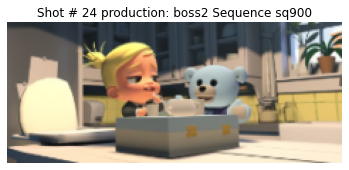

In [6]:
def shot_image(image_id, target_length=256, target_width=236):
    
    image_name = finalDf.iloc[image_id]["name"]
    shot_img = plt.imread(image_name)  # Reading in the image 
    shot_img_width = shot_img.shape[1]
    shot_img_height = shot_img.shape[0]
   
    img_target = np.zeros((target_length, target_width), np.uint8)
    scale_img_width = target_width
    scale_img_height = int( (float(scale_img_width)/shot_img_width) * shot_img_height)
    img_scaled = cv2.resize(shot_img, (scale_img_width, scale_img_height), interpolation = cv2.INTER_AREA)
    
    return img_scaled


shot_id = 24
shot_img = shot_image(shot_id, target_length=256)

plt.imshow(shot_img)
plt.title('Shot # {} production: {} Sequence {}'.format(str(shot_id),  finalDf.iloc[shot_id]["production"], finalDf.iloc[shot_id]["sequence"] ))

plt.axis('off')

plt.show()

In [7]:
# Now let's create a test/training set

X, X_test, y, y_test = train_test_split(finalDf["name"].copy(), 
                                        finalDf["ru_per_frame"], 
                                        test_size=0.2, 
                                        random_state=42)

X

2055     shots/boss2:sq3300:s101.png
1961       shots/boss2:sq2400:s1.png
1864    shots/boss2:sq2000:s17.1.png
2326     shots/trolls2:sq800:s21.png
461     shots/trolls2:sq2600:s36.png
                    ...             
1638     shots/badguys:sq750:s22.png
1095      shots/trolls2:sq50:s98.png
1130        shots/boss2:sq50:s28.png
1294        shots/boss2:sq950:s6.png
860       shots/boss2:sq2100:s22.png
Name: name, Length: 2000, dtype: object

## EDA Training and Test Datasets

* Imported 50000 examples for training and 10000 examples for test 
* Imported 50000 labels for training and 10000 labels for test 

In [8]:
print('train_images:\t{}'.format(X.shape))
print('train_ru:\t{}'.format(y.shape))
print('test_images:\t\t{}'.format(X_test.shape))
print('test_ru:\t\t{}'.format(y_test.shape))

train_images:	(2000,)
train_ru:	(2000,)
test_images:		(500,)
test_ru:		(500,)


## Review RU for training dataset

In [9]:
print("First ten ru values training dataset:\n {}\n".format(y[0:10]))

First ten ru values training dataset:
 2055    11.009627
1961     9.960281
1864    10.113613
2326     4.008785
461      6.938454
109      8.191019
1962     0.007269
354     16.759787
266      3.918017
1545     3.944353
Name: ru_per_frame, dtype: float64



<AxesSubplot:>

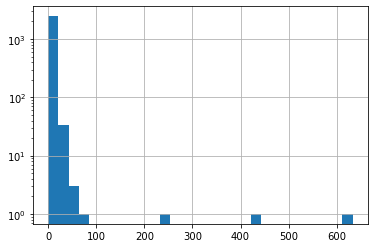

In [10]:
finalDf["ru_per_frame"].hist(bins=30,log=True)

<AxesSubplot:>

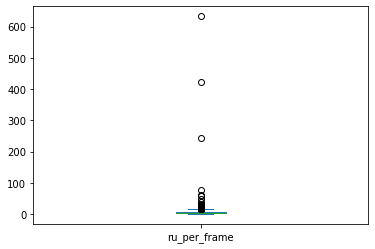

In [11]:
finalDf["ru_per_frame"].plot.box()

In [23]:
finalDf["ru_per_frame"].skew()

29.26735106938688

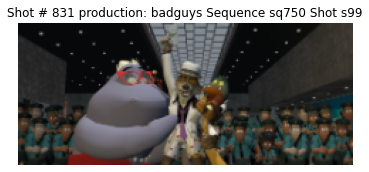

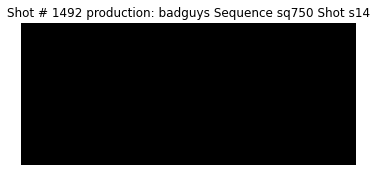

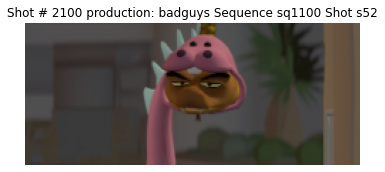

In [12]:
# Just looking at the top three RU per frame shots that loook like outliers to see what those are
top3 = finalDf[finalDf["ru_per_frame"] > 200]

for i in top3.index.values:
    #
    shot_id = i
    shot_img = shot_image(shot_id, target_length=256)

    plt.imshow(shot_img)
    plt.title('Shot # {} production: {} Sequence {} Shot {}'.format(str(shot_id),  
                                                                   finalDf.iloc[shot_id]["production"], 
                                                                   finalDf.iloc[shot_id]["sequence"], 
                                                                   finalDf.iloc[shot_id]["shot"] ))

    plt.axis('off')

    plt.show()

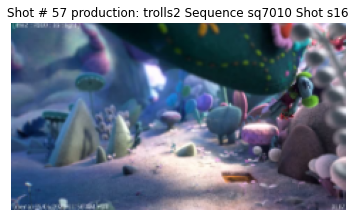

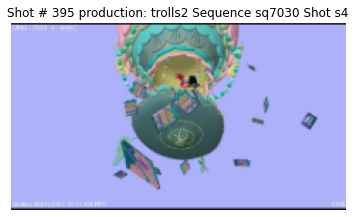

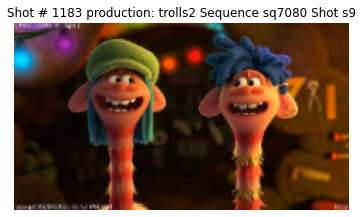

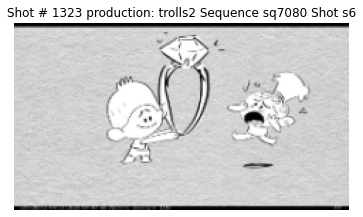

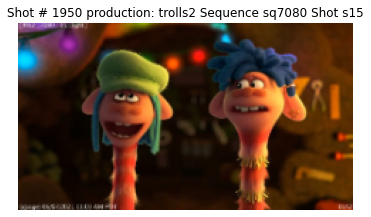

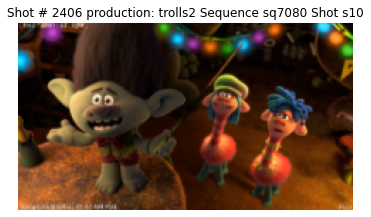

In [13]:
# Bottom RU values
bottomRU = finalDf[finalDf["ru_per_frame"] < 0.005]

for i in bottomRU.index.values:
    #
    shot_id = i
    shot_img = shot_image(shot_id, target_length=256)

    plt.imshow(shot_img)
    plt.title('Shot # {} production: {} Sequence {} Shot {}'.format(str(shot_id),  
                                                                   finalDf.iloc[shot_id]["production"], 
                                                                   finalDf.iloc[shot_id]["sequence"], 
                                                                   finalDf.iloc[shot_id]["shot"] ))

    plt.axis('off')

    plt.show()


## Create the Model

<img src="https://github.com/djp840/MSDS_458_Public/blob/master/images/CNN_architecture_v4.png?raw=1">


## Build CNN Model for Regression

We use a Sequential class defined in Keras to create our model. The first 9 layers Conv2D MaxPooling, Dropout handle feature learning.  The last 3 layers, handle regression

In [305]:
model = models.Sequential()
model.add(layers.Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu,input_shape=(128, 128, 3)))
model.add(layers.MaxPool2D((2, 2),strides=2))
model.add(layers.Dropout(0.4))
model.add(layers.Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu))
model.add(layers.MaxPool2D(pool_size=(2, 2),strides=2))
model.add(layers.Dropout(0.4))
model.add(layers.Conv2D(filters=512, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu))
model.add(layers.MaxPool2D(pool_size=(2, 2),strides=2))
model.add(layers.Dropout(0.4))
model.add(layers.Flatten())
model.add(layers.BatchNormalization())
model.add(layers.Dense(units=20, activation=tf.nn.tanh, kernel_regularizer='l1_l2'))
model.add(layers.Dense(units=1))

In [306]:
model.summary()

Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_429 (Conv2D)         (None, 126, 126, 128)     3584      
                                                                 
 max_pooling2d_69 (MaxPoolin  (None, 63, 63, 128)      0         
 g2D)                                                            
                                                                 
 dropout_58 (Dropout)        (None, 63, 63, 128)       0         
                                                                 
 conv2d_430 (Conv2D)         (None, 61, 61, 256)       295168    
                                                                 
 max_pooling2d_70 (MaxPoolin  (None, 30, 30, 256)      0         
 g2D)                                                            
                                                                 
 dropout_59 (Dropout)        (None, 30, 30, 256)     

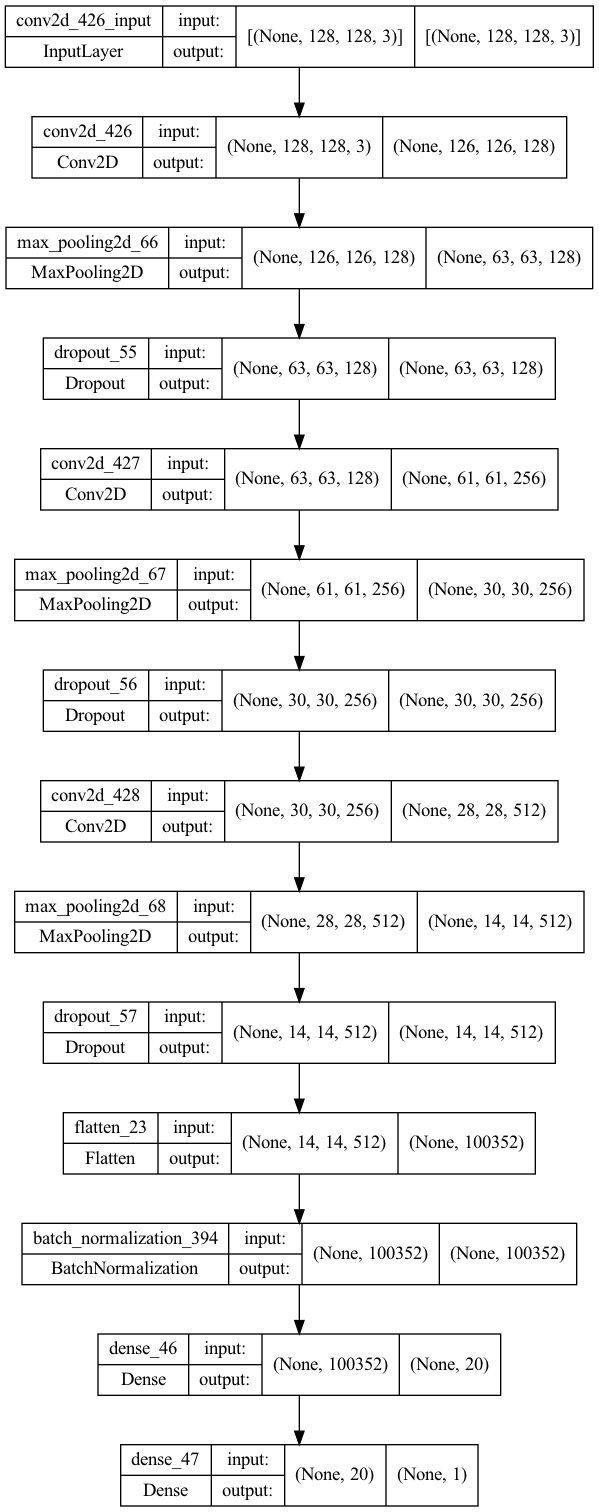

In [281]:
keras.utils.plot_model(model, "ru_regressor.png", show_shapes=True) 

## Compiling the model

In addition to setting up our model architecture, we also need to define which algorithm should the model use in order to optimize the weights and biases as per the given data. We will use stochastic gradient descent.

We also need to define a loss function. Think of this function as the difference between the predicted outputs and the actual outputs given in the dataset. This loss needs to be minimised in order to have a higher model accuracy. That's what the optimization algorithm essentially does - it minimises the loss during model training. For our regression problem, we can use Mean Squared Logarithmic Error, as that helped the model from divergence.

Finally, we will use the MAE during training as a metric to keep track of as the model trains.

<div class="alert alert-block alert-info">
<b>tf.keras.losses.MeanSquaredError</b><br>
https://www.tensorflow.org/api_docs/python/tf/keras/losses/MeanSquaredError</div>

In [307]:
model.compile(optimizer=tf.keras.optimizers.Adam(), #learning_rate=0.000000001, clipnorm=1
              #loss=tf.keras.losses.MeanSquaredLogarithmicError(reduction="auto", name="error"),
              loss=tf.keras.losses.MeanSquaredError(reduction="auto", name="error"),
              metrics=['mean_absolute_error', 'mean_absolute_percentage_error'])

## Training the model

<div class="alert alert-block alert-success">
    <b>Module: tf.keras.callbacks</b></div>

<div class="alert alert-block alert-info">
<b>tf.keras.callbacks.EarlyStopping</b><br>
https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping</div>

<div class="alert alert-block alert-info">
<b>tf.keras.callbacks.ModelCheckpoint</b><br>
https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint</div>

<div class="alert alert-block alert-info">
<b>tf.keras.callbacks.ImageDataGenerator</b><br>
https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator</div>

In [283]:
igen = ImageDataGenerator(
                rotation_range=10,
                zoom_range=0.1,
                horizontal_flip=False,
                vertical_flip=False,
                fill_mode='nearest',
                )

In [284]:
load_image_data(X).shape

(2000, 128, 128, 3)

In [19]:
imgsTestX = load_image_data(X_test).astype('f8')

In [308]:
history = model.fit(igen.flow(load_image_data(X), y, seed=42)
                    ,epochs=100
                    ,batch_size=200
                    ,validation_data=(imgsTestX, y_test)
                    ,callbacks=[
                    tf.keras.callbacks.EarlyStopping(monitor='val_mean_absolute_error', patience=5),
                    tf.keras.callbacks.ModelCheckpoint('results/model_{val_mean_absolute_error:.4f}.h5', save_best_only=True,
                                        save_weights_only=False, monitor='val_mean_absolute_error')]                                                                                                           
                   )

Epoch 1/100


2022-06-04 17:21:49.680717: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


63/63 [==============================] - ETA: 0s - loss: 429.8829 - mean_absolute_error: 5.3195 - mean_absolute_percentage_error: 1171.2566

2022-06-04 17:22:10.964722: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


63/63 [==============================] - 24s 370ms/step - loss: 429.8829 - mean_absolute_error: 5.3195 - mean_absolute_percentage_error: 1171.2566 - val_loss: 101.6248 - val_mean_absolute_error: 4.5759 - val_mean_absolute_percentage_error: 642.9388
Epoch 2/100
63/63 [==============================] - 23s 359ms/step - loss: 415.0433 - mean_absolute_error: 5.1707 - mean_absolute_percentage_error: 1076.6482 - val_loss: 98.9686 - val_mean_absolute_error: 4.4296 - val_mean_absolute_percentage_error: 547.5359
Epoch 3/100
63/63 [==============================] - 22s 346ms/step - loss: 421.2981 - mean_absolute_error: 5.5088 - mean_absolute_percentage_error: 1052.0967 - val_loss: 101.1259 - val_mean_absolute_error: 4.6152 - val_mean_absolute_percentage_error: 705.5327
Epoch 4/100
63/63 [==============================] - 22s 353ms/step - loss: 407.6125 - mean_absolute_error: 5.0699 - mean_absolute_percentage_error: 912.6607 - val_loss: 88.9210 - val_mean_absolute_error: 3.9862 - val_mean_absolut

## Validation Data
Data on which to evaluate the loss and any model metrics at the end of each epoch<br>
The model will not be trained on this data

## Evaluate the model

In order to ensure that this is not a simple "memorization" by the machine, we should evaluate the performance on the test set. This is easy to do, we simply use the `evaluate` method on our model.

In [316]:
loss, mae, mape = model.evaluate(imgsTestX, y_test)
print('test set mean avg percent error: ', mape)
print('test set mean absolute avg error: ', mae)

16/16 [==============================] - 3s 164ms/step - loss: 67.6133 - mean_absolute_error: 3.7534 - mean_absolute_percentage_error: 1366.9503
test set mean avg percent error:  1366.9503173828125
test set mean absolute avg error:  3.7534286975860596


## Predictions

In [310]:
preds = model.predict(imgsTestX)
print('shape of preds: ', preds.shape)

2022-06-04 17:26:34.411681: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


shape of preds:  (500, 1)


## Plotting Performance Metrics 

We use Matplotlib to create 2 plots--displaying the training and validation loss (resp. accuracy) for each (training) epoch side by side.

In [311]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'mean_absolute_error', 'mean_absolute_percentage_error', 'val_loss', 'val_mean_absolute_error', 'val_mean_absolute_percentage_error'])

In [312]:
history_df=pd.DataFrame(history_dict)
history_df.tail().round(3)

,loss,mean_absolute_error,mean_absolute_percentage_error,val_loss,val_mean_absolute_error,val_mean_absolute_percentage_error
7,370.456,3.936,1734.280,64.380,3.559,1517.538
8,367.788,4.012,1803.899,58.583,3.743,1704.329
9,370.373,4.047,1947.492,72.005,3.735,1826.912
10,368.341,4.031,1924.411,69.807,4.011,1841.716
11,376.911,4.162,2296.545,67.613,3.753,1366.950


In [313]:
losses = history.history['loss']
val_losses = history.history['val_loss']
accs = history.history['mean_absolute_error']
val_accs = history.history['val_mean_absolute_error']
epochs = len(losses)

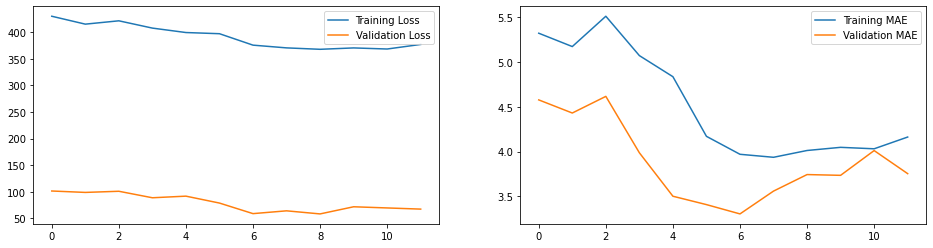

In [314]:
plt.figure(figsize=(16, 4))
for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'MAE'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
plt.show()

## Scatter plots
Visualize the regression scatter plots and see what that tells us.

Root Mean Squared Error: 5.503115079195146
R squared score: -44.79434487762827
Explained varience: -43.10776581624327


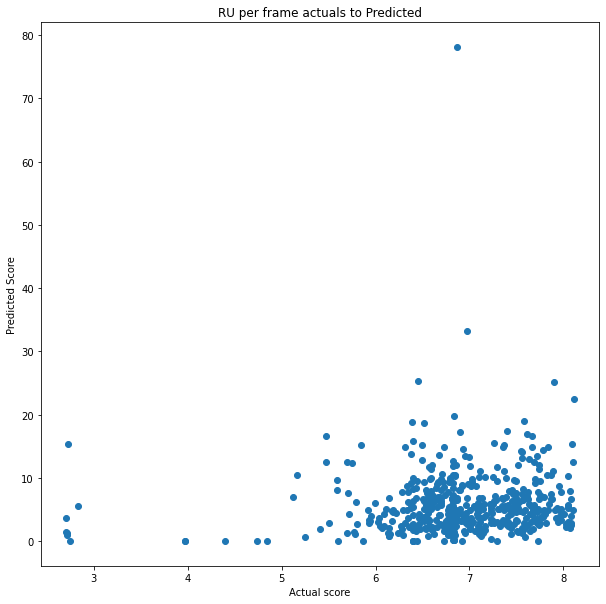

In [315]:
fig = plt.figure(figsize=(10,10))
ax1 = plt.subplot(111)

rmse1 = np.sqrt(MSE(preds, y_test))
print ("Root Mean Squared Error: %s" % rmse1)
r2 = R2(preds, y_test)
print ("R squared score: %s" % r2)
ev1 = EV(preds, y_test)
print ("Explained varience: %s" % ev1)

ax1.scatter(preds, y_test)
ax1.set_xlabel("Actual score")
ax1.set_ylabel("Predicted Score")
ax1.title.set_text("RU per frame actuals to Predicted")

## First three activation layers
Visualize the CNN filter layers

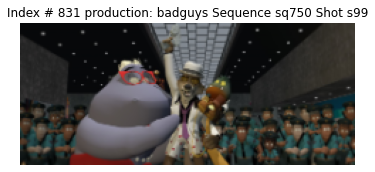

In [15]:
shot_id = 831
shot_img = shot_image(shot_id, target_length=256)

plt.imshow(shot_img)
plt.title('Index # {} production: {} Sequence {} Shot {}'.format(str(shot_id),  
                                                                 finalDf.iloc[shot_id]["production"], 
                                                                 finalDf.iloc[shot_id]["sequence"],
                                                                finalDf.iloc[shot_id]["shot"]))

plt.axis('off')

plt.show()

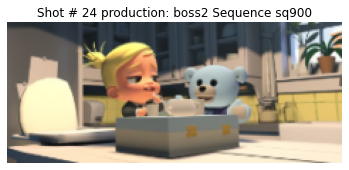

In [32]:
shot_id = 24
shot_img = shot_image(shot_id, target_length=256)

plt.imshow(shot_img)
plt.title('Shot # {} production: {} Sequence {}'.format(str(shot_id),  finalDf.iloc[shot_id]["production"], finalDf.iloc[shot_id]["sequence"] ))

plt.axis('off')

plt.show()

In [294]:
img_tensor = load_image_data([finalDf.iloc[shot_id]["name"]])

In [295]:
# Extracts the outputs of the top 8 layers:
layer_outputs = [layer.output for layer in model.layers[:8]]
# Creates a model that will return these outputs, given the model input:
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

In [296]:
activations = activation_model.predict(img_tensor)
len(activations)

2022-06-04 17:08:06.313130: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


8

In [297]:
layer_names = []
for layer in model.layers:
    layer_names.append(layer.name)
    
layer_names

['conv2d_426',
 'max_pooling2d_66',
 'dropout_55',
 'conv2d_427',
 'max_pooling2d_67',
 'dropout_56',
 'conv2d_428',
 'max_pooling2d_68',
 'dropout_57',
 'flatten_23',
 'batch_normalization_394',
 'dense_46',
 'dense_47']

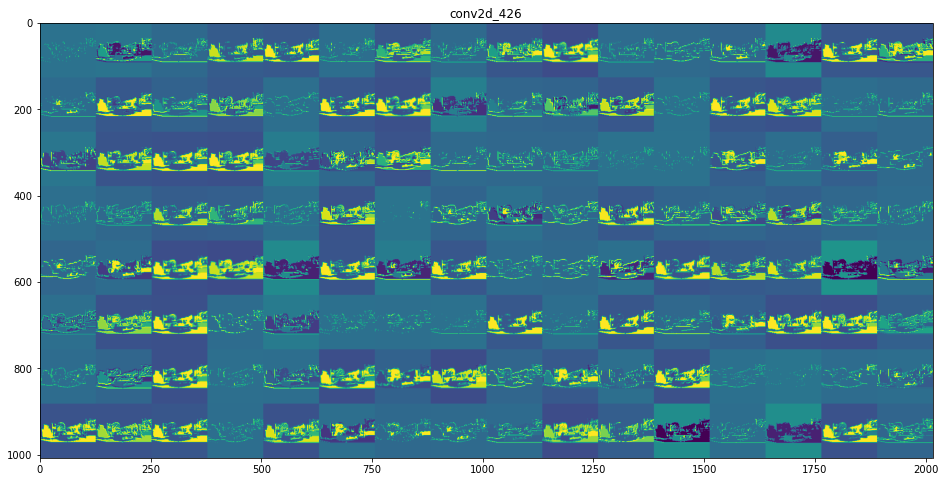

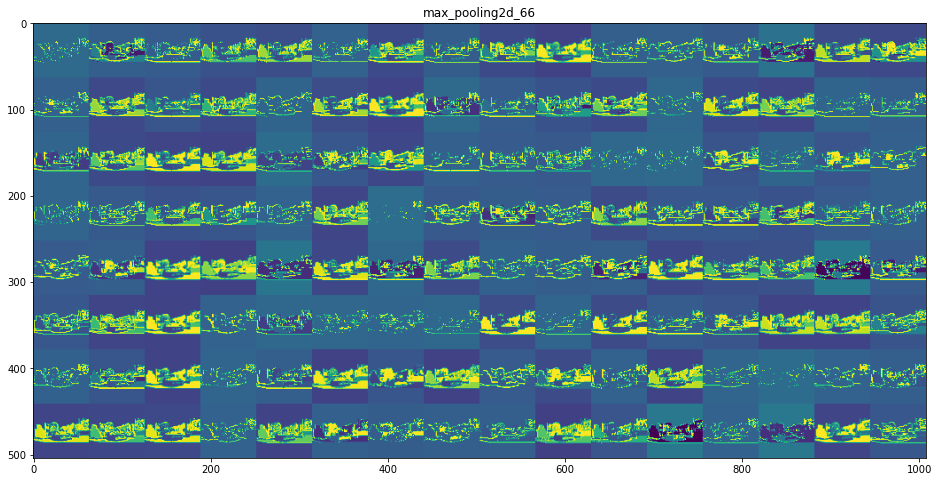

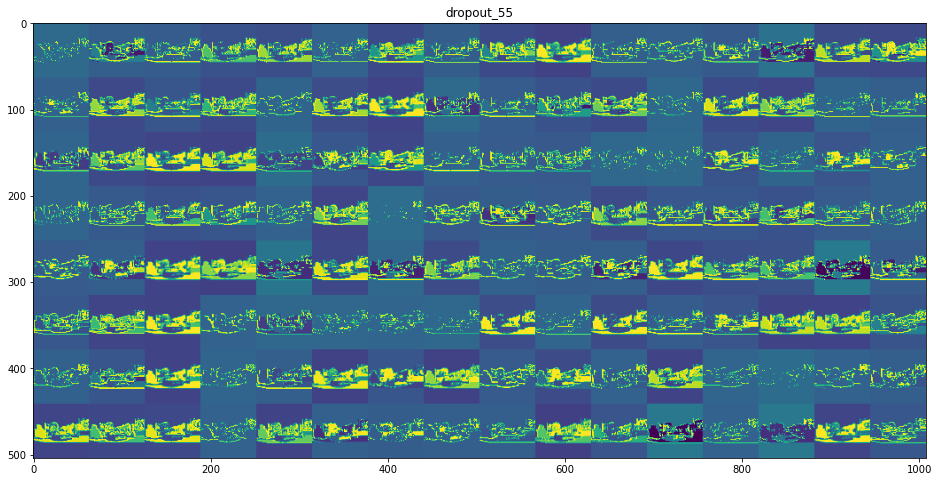

In [298]:
# These are the names of the layers, so can have them as part of our plot
layer_names = []
for layer in model.layers[:3]:
    layer_names.append(layer.name)

images_per_row = 16

# Now let's display our feature maps
for layer_name, layer_activation in zip(layer_names, activations):
    # This is the number of features in the feature map
    n_features = layer_activation.shape[-1]

    # The feature map has shape (1, size, size, n_features)
    size = layer_activation.shape[1]

    # We will tile the activation channels in this matrix
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))

    # We'll tile each filter into this big horizontal grid
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            # Post-process the feature to make it visually palatable
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size,
                         row * size : (row + 1) * size] = channel_image

    # Display the grid
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')
    
plt.show();

# Test improving CNN using Resnet50 model
Inception CNN with pretrained embeddings

In [317]:
# A method to create and run the models

import warnings
warnings.filterwarnings("ignore")

tf.autograph.set_verbosity(0)
import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)
logging.getLogger("scikeras").setLevel(logging.ERROR)

import random


def create_model_dnn(layers=1, nodes=200, activation=tf.nn.tanh):
    
    model1 = Sequential()
    model1.add(Input(shape=(128, 128, 3)))
    model1.add(tf.keras.layers.UpSampling2D(size=(2,2)))
    model1.add(tf.keras.applications.resnet.ResNet50(input_shape=(256, 256, 3), include_top=False, weights='imagenet'))
    model1.add(Flatten())
    model1.add(Dense(units=nodes, activation=activation, kernel_regularizer='l1_l2'))
    model1.add(Dropout(.3))
    model1.add(Dense(units=1))
    model1.summary()
    
    #And compile
    model1.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.MeanSquaredError(reduction="auto", name="error"),
              metrics=['mean_absolute_error', 'mean_absolute_percentage_error'])
    
    return model1

def run_dnn(layers=1, nodes=1, epochs=50):
    
    
    regressor = KerasRegressor(build_fn=lambda: create_model_dnn(layers=layers,
                                                                   nodes=nodes,), 
                                 callbacks=[EarlyStopping(patience=4, verbose=5, mode="auto")],
                                 verbose=5)
    
    
    start_time = timeit.default_timer()
    fit_hist = regressor.fit(load_image_data(X), y,
                              validation_data=(imgsTestX, y_test),
                              epochs=epochs, 
                              batch_size=200, 
                              verbose=5)
    stop_time = timeit.default_timer()


    print("Keras model with layers {num_layers} and nodes {num_nodes} fit time: {time}".format(time=round(stop_time - start_time, 2),
                                                                         num_layers=layers,
                                                                         num_nodes=nodes))
    
    
    
    return regressor, fit_hist

# One 384 nodes and two layers
reg_res, hist = run_dnn(layers=2, nodes=384)

Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 up_sampling2d_6 (UpSampling  (None, 256, 256, 3)      0         
 2D)                                                             
                                                                 
 resnet50 (Functional)       (None, 8, 8, 2048)        23587712  
                                                                 
 flatten_25 (Flatten)        (None, 131072)            0         
                                                                 
 dense_50 (Dense)            (None, 384)               50332032  
                                                                 
 dropout_61 (Dropout)        (None, 384)               0         
                                                                 
 dense_51 (Dense)            (None, 1)                 385       
                                                     

2022-06-04 19:51:25.073099: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-04 19:57:38.101184: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 2/50
Epoch 3/50
Epoch 4/50
Epoch 5/50
Epoch 6/50
Epoch 7/50


Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x42058f0a0>
    label = <none> 
    device = <AGXG13XDevice: 0x16433da00>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x164642e00>
        label = <none> 
        device = <AGXG13XDevice: 0x16433da00>
            name = Apple M1 Pro 
    retainedReferences = 1


Epoch 8/50
Epoch 9/50
Epoch 10/50
Epoch 11/50
Epoch 12/50
Epoch 13/50
Epoch 14/50
Epoch 15/50
Epoch 16/50
Epoch 17/50
Epoch 18/50
Epoch 19/50
Epoch 19: early stopping
Keras model with layers 2 and nodes 384 fit time: 6989.35


Root Mean Squared Error: 5.786627412803691
Mean Absolute Error: 1.8307093862121853
R squared score: -2268371.788027214
Explained varience: -1996146.1463323163


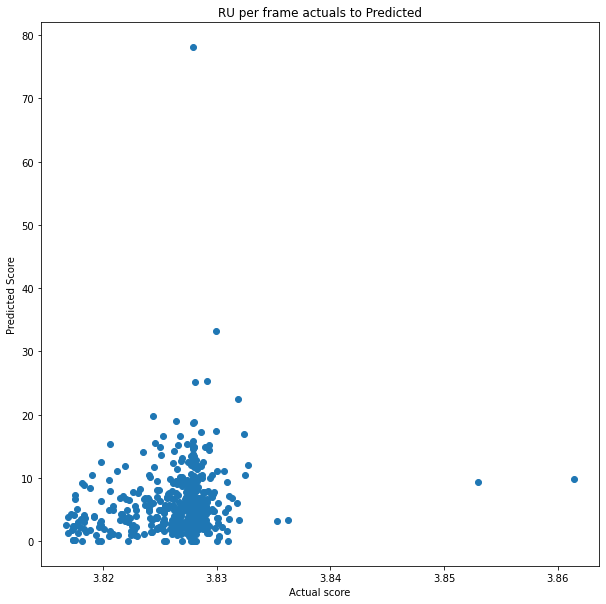

In [338]:
preds = clf.predict(imgsTestX)

fig = plt.figure(figsize=(10,10))
ax1 = plt.subplot(111)

rmse1 = np.sqrt(MSE(preds, y_test))
print ("Root Mean Squared Error: %s" % rmse1)
mae1 = np.sqrt(MAE(preds, y_test))
print ("Mean Absolute Error: %s" % mae1)
r2 = R2(preds, y_test)
print ("R squared score: %s" % r2)
ev1 = EV(preds, y_test)
print ("Explained varience: %s" % ev1)

ax1.scatter(preds, y_test)
ax1.set_xlabel("Actual score")
ax1.set_ylabel("Predicted Score")
ax1.title.set_text("RU per frame actuals to Predicted")

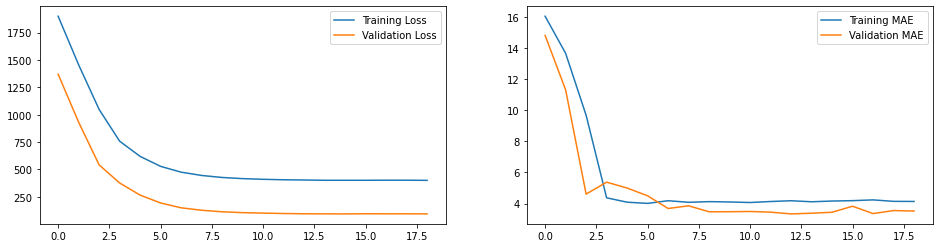

In [318]:
def plot_hist(hist):
    history = hist.history

    loss = history['loss']
    val_loss = history['val_loss']
    
    acc = history['mean_absolute_error']
    val_acc = history['val_mean_absolute_error']

    epochs_range = len(history['loss'])
    
    plt.figure(figsize=(16, 4))
    for i, metrics in enumerate(zip([loss, acc], [val_loss, val_acc], ['Loss', 'MAE'])):
        plt.subplot(1, 2, i + 1)
        plt.plot(range(epochs_range), metrics[0], label='Training {}'.format(metrics[2]))
        plt.plot(range(epochs_range), metrics[1], label='Validation {}'.format(metrics[2]))
        plt.legend()
    plt.show()

plot_hist(hist)

# Now try Inception


In [319]:
# A method to create and run the models

import warnings
warnings.filterwarnings("ignore")

tf.autograph.set_verbosity(0)
import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)
logging.getLogger("scikeras").setLevel(logging.ERROR)

import random


def create_model_dnn(layers=1, nodes=200, activation=tf.nn.tanh):
    
    model1 = Sequential()
    model1.add(Input(shape=(128, 128, 3)))
    model1.add(tf.keras.layers.UpSampling2D(size=(2,2)))
    model1.add(tf.keras.applications.inception_v3.InceptionV3(input_shape=(256, 256, 3), 
                                                              include_top=False, 
                                                              weights='imagenet'))
    model1.add(Flatten())
    model1.add(Dense(units=nodes,activation=activation, kernel_regularizer='l1_l2'))
    model1.add(Dropout(.3))
    model1.add(Dense(units=1))
    model1.summary()
    
    #And compile
    model1.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.MeanSquaredError(reduction="auto", name="error"),
              metrics=['mean_absolute_error', 'mean_absolute_percentage_error'])
    
    return model1

def run_dnn(layers=1, nodes=1, epochs=50):
    
    
    regressor = KerasRegressor(build_fn=lambda: create_model_dnn(layers=layers,
                                                                   nodes=nodes,), 
                                 callbacks=[EarlyStopping(patience=5, verbose=5, mode="auto")],
                                 verbose=5)
    
    
    start_time = timeit.default_timer()
    fit_hist = regressor.fit(load_image_data(X), y,
                              validation_data=(imgsTestX, y_test),
                              epochs=epochs, 
                              batch_size=200, 
                              verbose=5)
    stop_time = timeit.default_timer()


    print("Keras model with layers {num_layers} and nodes {num_nodes} fit time: {time}".format(time=round(stop_time - start_time, 2),
                                                                         num_layers=layers,
                                                                         num_nodes=nodes))
    
    
    
    return regressor, fit_hist

# One 384 nodes and two layers
model_inception, hist = run_dnn(layers=2, nodes=384)

Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 up_sampling2d_7 (UpSampling  (None, 256, 256, 3)      0         
 2D)                                                             
                                                                 
 inception_v3 (Functional)   (None, 6, 6, 2048)        21802784  
                                                                 
 flatten_26 (Flatten)        (None, 73728)             0         
                                                                 
 dense_52 (Dense)            (None, 384)               28311936  
                                                                 
 dropout_62 (Dropout)        (None, 384)               0         
                                                                 
 dense_53 (Dense)            (None, 1)                 385       
                                                     

2022-06-04 21:47:52.196047: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-04 21:50:31.150480: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 2/50
Epoch 3/50
Epoch 4/50
Epoch 5/50
Epoch 6/50
Epoch 7/50
Epoch 8/50
Epoch 9/50
Epoch 10/50
Epoch 11/50
Epoch 12/50
Epoch 13/50
Epoch 14/50
Epoch 15/50
Epoch 16/50
Epoch 17/50
Epoch 18/50
Epoch 18: early stopping
Keras model with layers 2 and nodes 384 fit time: 2780.66


Root Mean Squared Error: 5.551600480842683
Mean Absolute Error: 1.8109273627162332
R squared score: -773.5725996714848
Explained varience: -739.4184658932888


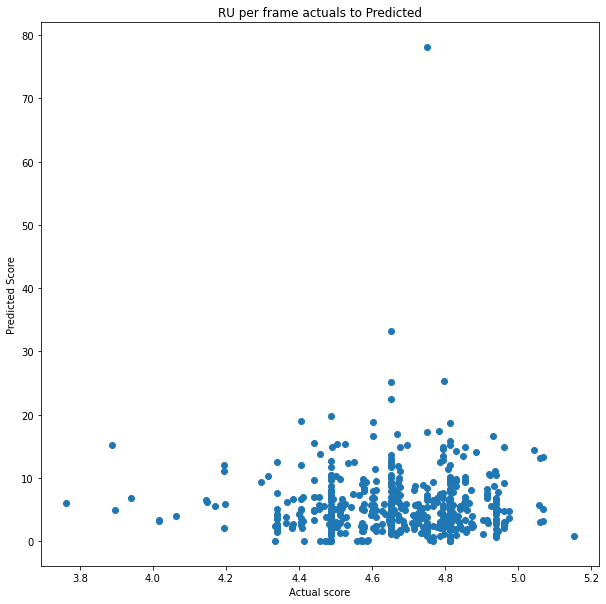

In [339]:
preds = model_inception.predict(imgsTestX)

fig = plt.figure(figsize=(10,10))
ax1 = plt.subplot(111)

rmse1 = np.sqrt(MSE(preds, y_test))
print ("Root Mean Squared Error: %s" % rmse1)
mae1 = np.sqrt(MAE(preds, y_test))
print ("Mean Absolute Error: %s" % mae1)
r2 = R2(preds, y_test)
print ("R squared score: %s" % r2)
ev1 = EV(preds, y_test)
print ("Explained varience: %s" % ev1)

ax1.scatter(preds, y_test)
ax1.set_xlabel("Actual score")
ax1.set_ylabel("Predicted Score")
ax1.title.set_text("RU per frame actuals to Predicted")

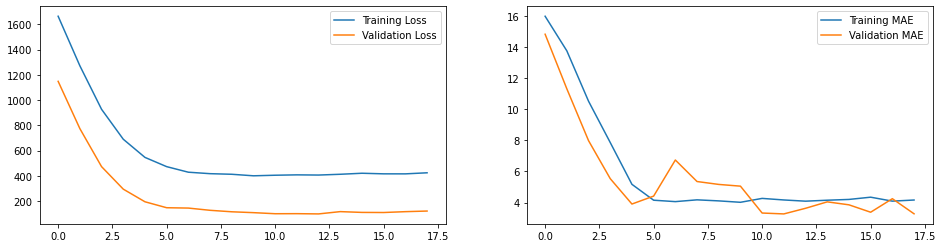

In [323]:
plot_hist(hist)

# Additional Trial

Create a ensemble of CNN models and then average the results of all the models for the final result.

We will also use data augmentation to enhance the training set.

In [14]:
number_of_models = 10
model_bag = []

import warnings
import random
import logging
import timeit

warnings.filterwarnings("ignore")

tf.autograph.set_verbosity(0)

logging.getLogger("tensorflow").setLevel(logging.ERROR)
logging.getLogger("scikeras").setLevel(logging.ERROR)


def create_conv_model(layers=1, nodes=256, init='glorot_normal'):
    
    all_layers = [tf.keras.layers.InputLayer(input_shape=(128, 128, 3))]
    
    # Conv 1
    all_layers.append(tf.keras.layers.Conv2D(128, (3,3), kernel_initializer=init, activation=tf.nn.relu, padding='Same') ) 
    all_layers.append(tf.keras.layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)) )
    all_layers.append(tf.keras.layers.Dropout(.4))
    
    # Conv 2
    all_layers.append(tf.keras.layers.Conv2D(256, (3,3), kernel_initializer=init, activation=tf.nn.relu, padding='Same') ) 
    all_layers.append(tf.keras.layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)) )
    all_layers.append(tf.keras.layers.Dropout(.4))
    
    # Conv 3
    all_layers.append(tf.keras.layers.Conv2D(512, (3,3), kernel_initializer=init, activation=tf.nn.relu, padding='Same') ) 
    all_layers.append(tf.keras.layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)) )
    all_layers.append(tf.keras.layers.Dropout(.4))
   
    
    all_layers.append(tf.keras.layers.Flatten() )
    all_layers.append(tf.keras.layers.BatchNormalization())
    
    for i in range(layers):
        all_layers.append(tf.keras.layers.Dense(nodes, kernel_initializer=init, activation=tf.nn.tanh, kernel_regularizer='l1_l2'))
        all_layers.append(tf.keras.layers.Dropout(.4))
        
                                         
    all_layers.append(tf.keras.layers.Dense(1))
    model = tf.keras.Sequential(all_layers)
    
    model.compile(tf.optimizers.Adam(), 
                  loss=tf.keras.losses.MeanSquaredError(reduction="auto", name="error"),
                  metrics=['mean_absolute_error', 'mean_absolute_percentage_error']
                 )
    
    return model

def run_multi_conv(layers=1, nodes=1, epochs=100):
    
    # Shuffle the test data on each run
    X_train, X_test, y_train, y_test = train_test_split(load_image_data(X), y, test_size=.1, shuffle=True)
    
    
    
    regressor = KerasRegressor(build_fn=lambda: create_conv_model(layers=layers,
                                                                   nodes=nodes,), 
                                 callbacks=[EarlyStopping(patience=5, verbose=5, mode="auto")],
                                 verbose=5)
    
    
    start_time = timeit.default_timer()
    fit_hist = regressor.fit(X_train, y_train,
                              validation_data=(X_test, y_test),
                              epochs=epochs, 
                              batch_size=400, 
                              verbose=5)
    stop_time = timeit.default_timer()


    print("CNN with layers {num_layers} and nodes {num_nodes} fit time: {time}".format(time=round(stop_time - start_time, 2),
                                                                         num_layers=layers,
                                                                         num_nodes=nodes))
    
    
    
    return regressor, fit_hist

for i in range(number_of_models):
    model_bag.append(run_multi_conv(layers=1, nodes=384))

Metal device set to: Apple M1 Pro


2022-06-05 12:36:09.858659: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-06-05 12:36:09.859075: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Epoch 1/100


2022-06-05 12:36:10.415876: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-06-05 12:36:10.664893: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-05 12:36:31.936621: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 2/100
Epoch 3/100
Epoch 4/100
Epoch 5/100
Epoch 6/100
Epoch 7/100
Epoch 8/100
Epoch 9/100
Epoch 10/100
Epoch 11/100
Epoch 12/100
Epoch 13/100
Epoch 14/100
Epoch 15/100
Epoch 16/100
Epoch 17/100
Epoch 18/100
Epoch 19/100
Epoch 20/100
Epoch 21/100
Epoch 22/100
Epoch 23/100
Epoch 24/100
Epoch 25/100
Epoch 26/100
Epoch 27/100
Epoch 28/100
Epoch 29/100
Epoch 30/100
Epoch 31/100
Epoch 31: early stopping
CNN with layers 1 and nodes 384 fit time: 628.97
Epoch 1/100


2022-06-05 12:46:41.858496: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-05 12:47:03.163760: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 2/100
Epoch 3/100
Epoch 4/100
Epoch 5/100
Epoch 6/100
Epoch 7/100
Epoch 8/100
Epoch 9/100
Epoch 10/100
Epoch 11/100
Epoch 12/100
Epoch 13/100
Epoch 14/100
Epoch 15/100
Epoch 16/100
Epoch 17/100
Epoch 18/100
Epoch 19/100
Epoch 20/100
Epoch 21/100
Epoch 22/100
Epoch 23/100
Epoch 24/100
Epoch 25/100
Epoch 26/100
Epoch 27/100
Epoch 28/100
Epoch 29/100
Epoch 30/100
Epoch 31/100
Epoch 32/100
Epoch 33/100
Epoch 34/100
Epoch 35/100
Epoch 36/100
Epoch 36: early stopping
CNN with layers 1 and nodes 384 fit time: 765.45
Epoch 1/100


2022-06-05 12:59:29.481436: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-05 12:59:50.458071: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 2/100
Epoch 3/100
Epoch 4/100
Epoch 5/100
Epoch 6/100
Epoch 7/100
Epoch 8/100
Epoch 9/100
Epoch 10/100
Epoch 11/100
Epoch 12/100
Epoch 13/100
Epoch 14/100
Epoch 15/100
Epoch 16/100
Epoch 17/100
Epoch 18/100
Epoch 19/100
Epoch 20/100
Epoch 21/100
Epoch 22/100
Epoch 23/100
Epoch 24/100
Epoch 25/100
Epoch 26/100
Epoch 27/100
Epoch 28/100
Epoch 29/100
Epoch 30/100
Epoch 31/100
Epoch 32/100
Epoch 33/100
Epoch 34/100
Epoch 35/100
Epoch 36/100
Epoch 37/100
Epoch 38/100
Epoch 39/100
Epoch 40/100
Epoch 41/100
Epoch 42/100
Epoch 43/100
Epoch 44/100
Epoch 45/100
Epoch 46/100
Epoch 47/100
Epoch 47: early stopping
CNN with layers 1 and nodes 384 fit time: 1011.12
Epoch 1/100


2022-06-05 13:16:23.418334: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-05 13:16:45.664896: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 2/100
Epoch 3/100
Epoch 4/100
Epoch 5/100
Epoch 6/100
Epoch 7/100
Epoch 8/100
Epoch 9/100
Epoch 10/100
Epoch 11/100
Epoch 12/100
Epoch 13/100
Epoch 14/100
Epoch 15/100
Epoch 16/100
Epoch 17/100
Epoch 18/100
Epoch 19/100
Epoch 20/100
Epoch 21/100
Epoch 22/100
Epoch 23/100
Epoch 24/100
Epoch 25/100
Epoch 26/100
Epoch 27/100
Epoch 28/100
Epoch 29/100
Epoch 30/100
Epoch 31/100
Epoch 32/100
Epoch 33/100
Epoch 34/100
Epoch 35/100
Epoch 36/100
Epoch 37/100
Epoch 38/100
Epoch 39/100
Epoch 39: early stopping
CNN with layers 1 and nodes 384 fit time: 845.74
Epoch 1/100


2022-06-05 13:30:31.105483: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-05 13:30:52.701470: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 2/100
Epoch 3/100
Epoch 4/100
Epoch 5/100
Epoch 6/100
Epoch 7/100
Epoch 8/100
Epoch 9/100
Epoch 10/100
Epoch 11/100
Epoch 12/100
Epoch 13/100
Epoch 14/100
Epoch 15/100
Epoch 16/100
Epoch 17/100
Epoch 18/100
Epoch 19/100
Epoch 20/100
Epoch 21/100
Epoch 22/100
Epoch 23/100
Epoch 24/100
Epoch 25/100
Epoch 26/100
Epoch 27/100
Epoch 28/100
Epoch 29/100
Epoch 30/100
Epoch 31/100
Epoch 32/100
Epoch 33/100
Epoch 34/100
Epoch 35/100
Epoch 36/100
Epoch 37/100
Epoch 38/100
Epoch 39/100
Epoch 40/100
Epoch 41/100
Epoch 42/100
Epoch 42: early stopping
CNN with layers 1 and nodes 384 fit time: 912.75
Epoch 1/100


2022-06-05 13:45:46.241263: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-05 13:46:08.742666: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 2/100
Epoch 3/100
Epoch 4/100
Epoch 5/100
Epoch 6/100
Epoch 7/100
Epoch 8/100
Epoch 9/100
Epoch 10/100
Epoch 11/100
Epoch 12/100
Epoch 13/100
Epoch 14/100
Epoch 15/100
Epoch 16/100
Epoch 17/100
Epoch 18/100
Epoch 19/100
Epoch 20/100
Epoch 21/100
Epoch 22/100
Epoch 23/100
Epoch 24/100
Epoch 25/100
Epoch 26/100
Epoch 27/100
Epoch 28/100
Epoch 29/100
Epoch 30/100
Epoch 31/100
Epoch 32/100
Epoch 33/100
Epoch 34/100
Epoch 35/100
Epoch 36/100
Epoch 37/100
Epoch 38/100
Epoch 39/100
Epoch 40/100
Epoch 41/100
Epoch 42/100
Epoch 43/100
Epoch 44/100
Epoch 45/100
Epoch 46/100
Epoch 47/100
Epoch 48/100
Epoch 49/100
Epoch 50/100
Epoch 51/100
Epoch 52/100
Epoch 53/100
Epoch 53: early stopping
CNN with layers 1 and nodes 384 fit time: 1213.38
Epoch 1/100


2022-06-05 14:09:52.909070: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-05 14:10:15.221302: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 2/100
Epoch 3/100
Epoch 4/100
Epoch 5/100
Epoch 6/100
Epoch 7/100
Epoch 8/100
Epoch 9/100
Epoch 10/100
Epoch 11/100
Epoch 12/100
Epoch 13/100
Epoch 14/100
Epoch 15/100
Epoch 16/100
Epoch 17/100
Epoch 18/100
Epoch 19/100
Epoch 20/100
Epoch 21/100
Epoch 22/100
Epoch 23/100
Epoch 23: early stopping
CNN with layers 1 and nodes 384 fit time: 539.76
Epoch 1/100


2022-06-05 14:18:54.932794: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-05 14:19:17.808912: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 2/100
Epoch 3/100
Epoch 4/100
Epoch 5/100
Epoch 6/100
Epoch 7/100
Epoch 8/100
Epoch 9/100
Epoch 10/100
Epoch 11/100
Epoch 12/100
Epoch 13/100
Epoch 14/100
Epoch 15/100
Epoch 16/100
Epoch 17/100
Epoch 18/100
Epoch 19/100
Epoch 20/100
Epoch 21/100
Epoch 22/100
Epoch 23/100
Epoch 24/100
Epoch 25/100
Epoch 26/100
Epoch 27/100
Epoch 28/100
Epoch 29/100
Epoch 30/100
Epoch 31/100
Epoch 32/100
Epoch 33/100
Epoch 34/100
Epoch 35/100
Epoch 36/100
Epoch 37/100
Epoch 38/100
Epoch 39/100
Epoch 40/100
Epoch 41/100
Epoch 42/100
Epoch 43/100
Epoch 44/100
Epoch 45/100
Epoch 46/100
Epoch 47/100
Epoch 48/100
Epoch 49/100
Epoch 50/100
Epoch 51/100
Epoch 52/100
Epoch 53/100
Epoch 54/100
Epoch 55/100
Epoch 56/100
Epoch 57/100
Epoch 58/100
Epoch 59/100
Epoch 60/100
Epoch 61/100
Epoch 62/100
Epoch 63/100
Epoch 64/100
Epoch 65/100
Epoch 66/100
Epoch 67/100
Epoch 68/100
Epoch 69/100
Epoch 70/100
Epoch 71/100
Epoch 72/100
Epoch 73/100
Epoch 74/100
Epoch 75/100
Epoch 76/100
Epoch 76: early stopping
CNN with

2022-06-05 14:49:01.030211: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-05 14:49:25.321954: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 2/100
Epoch 3/100
Epoch 4/100
Epoch 5/100
Epoch 6/100
Epoch 7/100
Epoch 8/100
Epoch 9/100
Epoch 10/100
Epoch 11/100
Epoch 12/100
Epoch 13/100
Epoch 14/100
Epoch 15/100
Epoch 16/100
Epoch 17/100
Epoch 18/100
Epoch 19/100
Epoch 20/100
Epoch 21/100
Epoch 22/100
Epoch 23/100
Epoch 24/100
Epoch 25/100
Epoch 26/100
Epoch 27/100
Epoch 28/100
Epoch 29/100
Epoch 30/100
Epoch 31/100
Epoch 32/100
Epoch 33/100
Epoch 34/100
Epoch 35/100
Epoch 36/100
Epoch 37/100
Epoch 38/100
Epoch 39/100
Epoch 40/100
Epoch 41/100
Epoch 42/100
Epoch 43/100
Epoch 44/100
Epoch 45/100
Epoch 46/100
Epoch 47/100
Epoch 48/100
Epoch 49/100
Epoch 50/100
Epoch 51/100
Epoch 52/100
Epoch 53/100
Epoch 54/100
Epoch 55/100
Epoch 56/100
Epoch 57/100
Epoch 58/100
Epoch 59/100
Epoch 60/100
Epoch 61/100
Epoch 62/100
Epoch 62: early stopping
CNN with layers 1 and nodes 384 fit time: 1527.56
Epoch 1/100


2022-06-05 15:14:30.828018: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-05 15:14:55.552054: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 2/100
Epoch 3/100
Epoch 4/100
Epoch 5/100
Epoch 6/100
Epoch 7/100
Epoch 8/100
Epoch 9/100
Epoch 10/100
Epoch 11/100
Epoch 12/100
Epoch 13/100
Epoch 14/100
Epoch 15/100
Epoch 16/100
Epoch 17/100
Epoch 18/100
Epoch 19/100
Epoch 20/100
Epoch 21/100
Epoch 22/100
Epoch 23/100
Epoch 24/100
Epoch 25/100
Epoch 26/100
Epoch 27/100
Epoch 28/100
Epoch 29/100
Epoch 30/100
Epoch 31/100
Epoch 32/100
Epoch 33/100
Epoch 34/100
Epoch 35/100
Epoch 36/100
Epoch 37/100
Epoch 38/100
Epoch 39/100
Epoch 40/100
Epoch 41/100
Epoch 41: early stopping
CNN with layers 1 and nodes 384 fit time: 992.13


array([[<AxesSubplot:title={'center':'model_times'}>]], dtype=object)

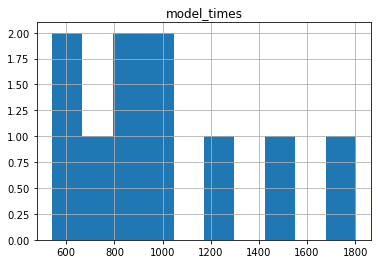

In [16]:
model_training_times = [628.97, 765.45, 1011.12, 845.74,
                        912.75, 1213.38, 539.76, 1803.72, 
                        1527.56, 992.13]

ttimes = pd.DataFrame({"model_times": model_training_times})
ttimes.hist()

In [17]:
ttimes.describe()

,model_times
count,10.000000
mean,1024.058000
std,394.422315
min,539.760000
25%,785.522500
50%,952.440000
75%,1162.815000
max,1803.720000


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 128)     3584      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 128)      0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 64, 64, 128)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 256)       295168    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 256)      0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 32, 32, 256)       0

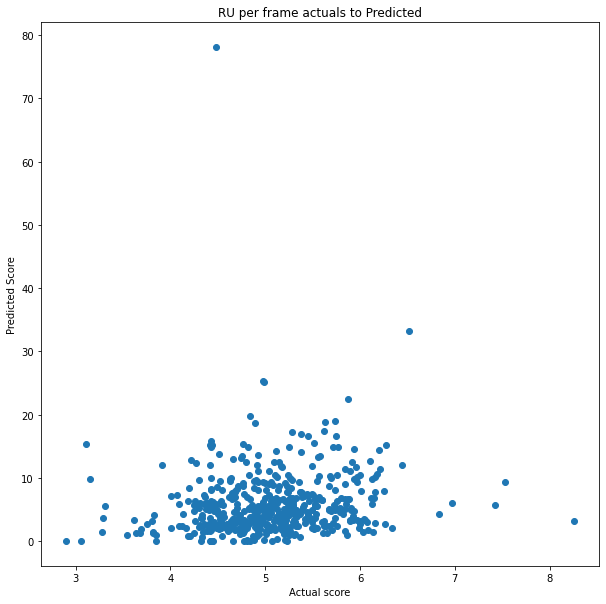

In [27]:
def multi_conv_test(models):
    
    models[0][0].model.summary()
    
    allPreds = []
    isFirst = True
    
    i = 0
    for m, hist in models:
        
        allPreds.insert(i, np.array(m.predict(imgsTestX)))
        i = i + 1
        
    #Use the average of each model's predictions as the final value
    m = np.mean(allPreds, axis=0)
    preds = m
    
    # Let's also print some stas
    print("Root Mean Squared Error: {:.3f}".format(np.sqrt(MSE(preds, y_test))))
    print("Mean Absolute Error: {:.3f}".format(MAE(preds, y_test)))
    print("R2 score: {:.3f}".format(R2(preds, y_test)))
    print("Explained Varience score: {:.3f}".format(EV(preds, y_test)))
    
    fig = plt.figure(figsize=(10,10))
    ax1 = plt.subplot(111)
    
    ax1.scatter(preds, y_test)
    ax1.set_xlabel("Actual score")
    ax1.set_ylabel("Predicted Score")
    ax1.title.set_text("RU per frame actuals to Predicted")
    
    return preds
    
predictions = multi_conv_test(model_bag)

In [30]:
for m, hist in model_bag:
    loss, mae, mape = m.model.evaluate(imgsTestX, y_test)
    print('test set mean avg percent error: ', mape)
    print('test set mean absolute avg error: ', mae)
    print('test set mean squared error: ', loss)
    
    

16/16 [==============================] - 4s 248ms/step - loss: 180.0730 - mean_absolute_error: 3.5997 - mean_absolute_percentage_error: 661.2556
test set mean avg percent error:  661.2555541992188
test set mean absolute avg error:  3.5997493267059326
test set mean squared error:  180.07301330566406
16/16 [==============================] - 4s 255ms/step - loss: 137.5361 - mean_absolute_error: 3.2185 - mean_absolute_percentage_error: 1016.0309
test set mean avg percent error:  1016.0308837890625
test set mean absolute avg error:  3.218492031097412
test set mean squared error:  137.5360870361328
16/16 [==============================] - 4s 250ms/step - loss: 138.9331 - mean_absolute_error: 3.2778 - mean_absolute_percentage_error: 1194.5786
test set mean avg percent error:  1194.57861328125
test set mean absolute avg error:  3.277787685394287
test set mean squared error:  138.9330596923828
16/16 [==============================] - 4s 247ms/step - loss: 146.1808 - mean_absolute_error: 3.3649 

array([[<AxesSubplot:title={'center':'model_mae'}>]], dtype=object)

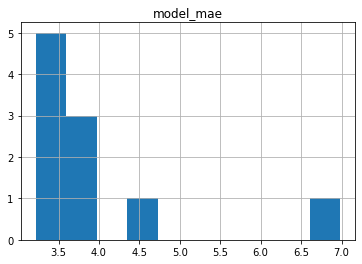

In [31]:
mae_scores = [3.5997, 3.2185, 3.2778, 3.3649, 3.6539,
             3.2991, 4.6834, 3.2756, 6.9831, 3.6862,]

maes = pd.DataFrame({"model_mae": mae_scores})
maes.hist()

In [34]:
%%bash 

jupyter-nbconvert --to PDFviaHTML MSDS458_Final.ipynb

[NbConvertApp] Converting notebook MSDS458_Final.ipynb to PDFviaHTML
[NbConvertApp] Writing 5988555 bytes to MSDS458_Final.pdf
